# Calibração de modelos (*Uncertainty calibration*)

## Introdução

### Interpretando *scores* como probabilidades

Diversos modelos de classificação binária podem apresentar como saída um valor contínuo entre 0 e 1, muitas vezes chamado de *score*. Esse valor é geralmente convertido na classe correspondente (0 ou 1) de acordo com um valor de corte, em geral 0,5. Ou seja, a amostra é classificada como pertencente à classe 1 se o valor for maior que 0.5, ou à classe 0 se for menor que 0,5.

É comum encontrarmos na literatura a associação desses valores a **probabilidades**. Por exemplo, uma amostra cuja predição seja de 0,6 pode ser indicada como possuindo 60% de probabilidade de pertencer à classe positiva (1). Da mesma forma, pode ser dito que uma predição de 0,9 é **mais confiável** que uma de 0,6. Em modelos usados na medicina, essas probabilidades podem também ser chamadas de **riscos**: uma predição de 0,9 indicaria um alto risco para uma doença [[JCE](https://www.sciencedirect.com/science/article/abs/pii/S0895435615005818)].

### O que é um modelo calibrado?

Os *scores* realmente podem fornecer essa interpretação probabilística, porém, ela só será válida se o modelo estiver **calibrado**. Dessa forma, dizemos que a calibração de um modelo está relacionada com a concordância entre suas predições e a frequência relativa observada do evento. 

Um exemplo do dia-a-dia são as previsões do tempo [[TDS1](https://towardsdatascience.com/introduction-to-reliability-diagrams-for-probability-calibration-ed785b3f5d44)]. O que significa uma probabilidade de 20% de chuva? Na prática, podemos imaginar que, se considerarmos todos os dias em que a probabilidade de chuva é predita como 20% ao longo de vários anos, de fato, choverá em 20% desses dias. De outra forma, se de todos os dias em que o modelo previu a probabilidade de chuva como 20%, chovesse em 40% dos dias, diríamos que o modelo está mal calibrado. Assim, com um modelo mal calibrado, perdemos a **confiabilidade** na interpretação da sua saída como uma probabilidade. 

Note que calibração e capacidade preditiva não necessariamente andam juntas. Por exemplo, em um contexto médico [[BMC Med](https://bmcmedicine.biomedcentral.com/articles/10.1186/s12916-019-1466-7)], um modelo bem calibrado com menor capacidade preditiva pode ser mais útil que um modelo mal calibrado, pois o risco associado a uma predição pode ser um fator crucial para decidir entre iniciar um tratamento ou não. Em outros contextos, porém, podemos estar interessados apenas nas classes binárias (0 e 1). Assim, tanto faz se o modelo prevê uma amostra negativa como 0,1 ou 0,4, já que ambas serão classificadas como 0 (se o valor de corte for 0,5). Conclui-se que um modelo, mesmo mal calibrado, ainda pode apresentar boas métricas de qualidade, como acurácia, e ser útil em diversas aplicações.

### Fatores que prejudicam a calibração

Alguns algoritmos, por natureza, costumam fornecer modelos bem calibrados. Alguns exemplos são: regressão logística, *Naive Bayes* e *Linear Discriminant Analysis* (LDA). Os algoritmos de redes neurais foram por muito tempo considerados como fornecedores de modelos bem calibrados, mas isso tem sido contestado nos últimos anos [[IEEE](https://ieeexplore.ieee.org/document/8851962)]. Outros algoritmos também podem gerar modelos que fornecem *scores* entre 0 e 1, porém, esses valores muitas vezes não são calibrados. Exemplos são: SVM, k-NN e árvores de decisão. Particularmente interessantes são os modelos do tipo *ensemble* de árvores de decisão, como Random Forest e XGBoost, que tendem a fornecer modelos descalibrados "nas extremidades" [[SKL1](https://scikit-learn.org/stable/modules/calibration.html)]: é muito difícil a predição de um modelo do tipo *ensemble* ser próxima de 0 ou 1, já que seria necessário que as predições de quase todas as árvores fossem iguais a 0 ou 1.

Um viés nos dados (dados desbalanceados) também pode prejudicar a calibração, uma vez que o modelo tenderá a prever uma probabilidade maior para a classe majoritária. O sobreajuste (*overfitting*) também prejudica a calibração.

### Como calibrar modelos

As predições feitas por um modelo mal calibrado podem ser calibradas por meio de um redimensionamento (*scaling*) dos seus valores, para que correspondam melhor à distribuição observada nos dados. Em outras palavras, encontramos uma função que mapeia os valores preditos pelo modelo para valores que correspondam a probabilidades correspondentes às classes das amostras.

Diversos métodos podem ser usados para calibrar modelos, como: *Platt scaling*, *Isotonic regression*, *Beta calibration*, *Venn-Abers predictors* e *Histogram binning*. Não vou entrar em detalhes teóricos, mas apresentaremos um desses métodos abaixo, e você pode encontrar mais informações nesses *links* (em inglês): [[MLM1](https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/), [PMLR](https://proceedings.mlr.press/v70/guo17a/guo17a.pdf), [ABZ](https://www.abzu.ai/explanation/calibration-introduction-part-2/), [TDS2](https://towardsdatascience.com/a-comprehensive-guide-on-model-calibration-part-1-of-4-73466eb5e09a)].

Ressalto aqui que alguns desses métodos são considerados inferiores ou desatualizados, recomendando-se outras abordagens, como os métodos de [predição conforme](https://medium.com/data-hackers/calibrando-modelos-de-classifica%C3%A7%C3%A3o-bin%C3%A1ria-com-previs%C3%A3o-conforme-f547e68602ee). Não abordaremos esses métodos aqui, mas posso fazer outro *Notebook* no futuro.

### Diagrama de confiabilidade

Para verificar se um modelo está calibrado podemos gerar o **diagrama de confiabilidade** (*reliability diagram*, também chamado de *calibration plot*) para suas predições. Esse diagrama compara as predições feitas pelo modelo com a distribuição das classes no conjunto de dados. Vou mostrar mais detalhes abaixo, com código.

### Neste *Notebook*

Vamos começar mostrando o que é o diagrama de confiabilidade e como criá-lo usando o `scikit-learn`.

Em seguida, veremos como medir a calibração de um modelo de classificação binária.

Finalmente, vou apresentar algumas situações que prejudicam a calibração das incertezas dos modelos e mostrar métodos que podem ser usados para treinar modelos calibrados ou calibrar modelos já treinados.

## Importar módulos (e mostrar versões)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import numpy as np
import imblearn
import pandas as pd
import sklearn

print("Versões")
print("imbalanced-learn:", imblearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

Versões
imbalanced-learn: 0.11.0
matplotlib: 3.5.2
numpy: 1.22.3
pandas: 1.4.2
scikit-learn: 1.2.2


## Um exemplo simples de diagrama de confiabilidade

Vou descrever passo a passo como é gerado o diagrama, e, em seguida, mostrar a implementação do `scikit-learn`.

Tendo separado seu conjunto de dados em treinamento e teste, e treinado o modelo no conjunto de treinamento, gere as predições para o conjunto de teste. Suponha que os resultados tenham sido os seguintes:

```
y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9, 1.0])  # predições
y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])  # valores verdadeiros das classes
```

Em seguida, separamos os valores das predições em blocos (*bins*).

No exemplo, vamos considerar 3 blocos, de forma que o bloco 1 contenha as predições no intervalo \[0, 0.333), o bloco 2 no intervalo \[0.333, 0.667), o bloco 3, no intervalo \[0.667, 1.0). Mais blocos podem ser usados quando há mais dados disponíveis. Alternativamente, [quantis](https://pt.wikipedia.org/wiki/Quantil) podem ser usados. No exemplo, estes seriam os blocos (e as classes correspondentes): 

- Bloco 1: [0.1, 0.2, 0.3] --> [0, 0, 0]
- Bloco 2: [0.4, 0.65] --> [0, 1]
- Bloco 3: [0.7, 0.8, 0.9, 1.0] --> [1, 1, 1, 1]

Agora, comparamos a média das predições em cada bloco com as frequências relativas dos exemplos positivos. Em termos mais concretos, vamos verificar se as predições do Bloco 1, cuja média no nosso exemplo é de 0.2, contém de fato cerca de 20% de amostras positivas (dessa forma, confirmamos que as predições nesse intervalo possuem, de fato, cerca de 20% de probabilidade de pertencerem à classe 1).

Após fazer isso para todas as classes, geramos um gráfico de dispersão indicando os valores observados e os esperados para um modelo **perfeitamente calibrado (diagonal)**.

Veja como fazer isso no `scikit-learn`:

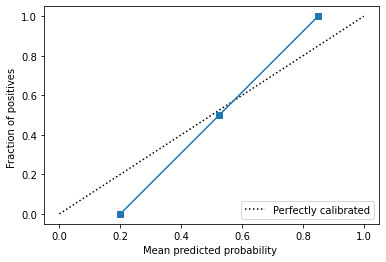

In [3]:
import numpy as np
from sklearn.calibration import calibration_curve, CalibrationDisplay

y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9, 1.0])

prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred)
disp.plot();

Vemos que as predições não estão perfeitamente calibradas, mas estão próximas da diagonal. No Bloco 1, por exemplo, temos a média de 0.2, mas todas as amostras pertencem à classe negativa (0), ou seja, se o modelo fosse perfeitamente calibrado, os *scores* para esse bloco deveriam ser todos iguais a 0.0. Dessa forma, podemos dizer que o modelo está "muito conservador" ou "pouco confiante" para as predições deste bloco. 

É claro que esse foi um exemplo muito simples, com apenas três amostras no primeiro bloco. Vamos ver um exemplo com mais dados:

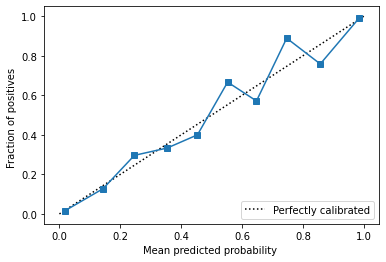

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Criar dados artificiais
X, y = make_classification(n_samples=5000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Treinar modelo
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

# Gerar predições (scores)
y_prob = clf.predict_proba(X_test)[:, 1]

# Gerar curva de calibração - com mais dados, podemos usar 10 blocos (n_bins=10)
# As legendas ficam em inglês pois o gráfico é gerado automaticamente pelo scikit-learn
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot();

Nota: versões anteriores da função `calibration_curve` continham o parâmetro `normalize`, para ser usado com modelos cujas predições não estão no intervalo [0,1] (por exemplo, [SVM](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)). O `scikit-learn` removeu essa possibilidade a partir da versão 1.3, recomendando o uso da função `calibration_curve` apenas com modelos que fornecem valores no intervalo [0,1] como saída.

## Discriminação x calibração

[Este *blog post*](https://changhsinlee.com/python-calibration-plot/) tem um exemplo muito bom, que vou traduzir abaixo:

> A discriminação é um conceito que anda lado a lado com a calibração em problemas de classificação. Às vezes, pode ser mais importante que a calibração, se o objetivo do modelo for tomar decisões automáticas em vez de fornecer estimativas estatísticas. Imagine o cenário em que tenho dois modelos meteorológicos e moro em Podunk, Nevada, onde 10% dos dias em um ano (36 dias por ano) são chuvosos:

> - o modelo A sempre diz que há 10% de chance de chover, não importa o dia.
> - o modelo B diz que vai chover todos os dias (100%) de junho (o mês mais chuvoso) e que nunca chove nos outros 11 meses (0%).

> Quando criamos os diagramas de confiabilidade, vemos que o modelo A está perfeitamente calibrado, já que todas as previsões estão em apenas um bloco (P=0,1) e, de fato, a verdadeira probabilidade de chover em qualquer dia no ano é de 10%. O modelo B, no entanto, é ligeiramente mal calibrado, porque haverá 30 dias no bloco P=1,0, mas também 6 dias chuvosos no bloco P=0,0. É claro, porém, que o modelo B é mais útil se estivermos fazendo planos para caminhadas no fim de semana. O modelo B é **mais discriminativo** do que o A, porque é mais fácil tomar decisões (caminhar/não caminhar) com base nos resultados do modelo B.

O autor finaliza comentando que a discriminação pode ser verificada com outras métricas, como ROC/AUC.


## Destruindo a calibração de modelos

Métodos comumente usados para lidar com dados desbalanceados, como *oversampling* (SMOTE) ou o ajuste dos pesos das classes, impactam negativamente a calibração dos modelos. 

Vejamos um exemplo a seguir, em que treinamos três modelos com diferentes estratégias:

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Criando um dataset desbalanceado
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15, n_redundant=5,
                           weights=[0.8], flip_y=0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 1. Treinar modelo "baseline", sem levar em conta o desbalanceamento

clf_1 = LogisticRegression(random_state=0)
clf_1.fit(X_train, y_train)

# Predições
y_pred_1 = clf_1.predict(X_test)
y_pred_proba_1 = clf_1.predict_proba(X_test)[:, 1]

# Métricas
print(f"Acurácia - modelo baseline: {accuracy_score(y_test, y_pred_1):.3f}")
print(f"F1-score - modelo baseline: {f1_score(y_test, y_pred_1):.3f}")
print(f"ROC/AUC  - modelo baseline: {roc_auc_score(y_test, y_pred_proba_1):.3f}")

# 2. Treinar modelo levando em conta o desbalanceamento usando class_weight='balanced'

clf_2 = LogisticRegression(class_weight='balanced', random_state=0)
clf_2.fit(X_train, y_train)

# Predições
y_pred_2 = clf_2.predict(X_test)
y_pred_proba_2 = clf_2.predict_proba(X_test)[:, 1]

# Métricas
print(f"Acurácia com class_weight='balanced': {accuracy_score(y_test, y_pred_2):.3f}")
print(f"F1-score com class_weight='balanced': {f1_score(y_test, y_pred_2):.3f}")
print(f"ROC/AUC  com class_weight='balanced': {roc_auc_score(y_test, y_pred_proba_2):.3f}")

# 3. Treinar modelo levando em conta o desbalanceamento usando SMOTE

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
clf_3 = LogisticRegression(random_state=0)
clf_3.fit(X_train_smote, y_train_smote)

# Predições
y_pred_3 = clf_3.predict(X_test)
y_pred_proba_3 = clf_3.predict_proba(X_test)[:, 1]

# Métricas
print(f"Acurácia com SMOTE: {accuracy_score(y_test, y_pred_3):.3f}", )
print(f"F1-score com SMOTE: {f1_score(y_test, y_pred_3):.3f}")
print(f"ROC/AUC  com SMOTE: {roc_auc_score(y_test, y_pred_proba_3):.3f}")

Acurácia - modelo baseline: 0.818
F1-score - modelo baseline: 0.404
ROC/AUC  - modelo baseline: 0.820
Acurácia com class_weight='balanced': 0.742
F1-score com class_weight='balanced': 0.540
ROC/AUC  com class_weight='balanced': 0.826
Acurácia com SMOTE: 0.752
F1-score com SMOTE: 0.550
ROC/AUC  com SMOTE: 0.825


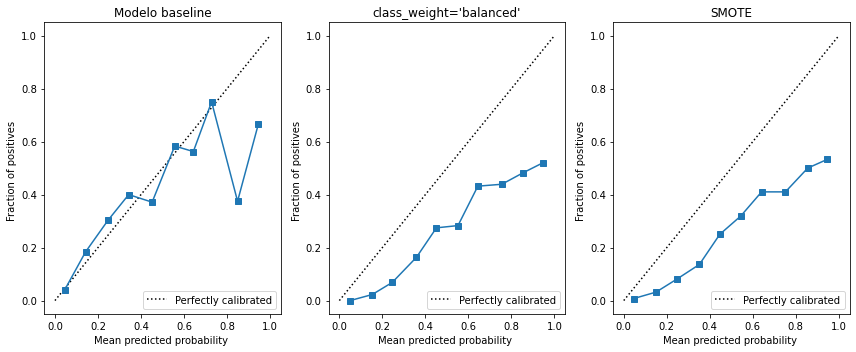

In [6]:
# Diagramas de confiabilidade
import matplotlib.pyplot as plt

prob_true1, prob_pred1 = calibration_curve(y_test, y_pred_proba_1, n_bins=10)
plot1 = CalibrationDisplay(prob_true1, prob_pred1, y_pred_proba_1)

prob_true2, prob_pred2 = calibration_curve(y_test, y_pred_proba_2, n_bins=10)
plot2 = CalibrationDisplay(prob_true2, prob_pred2, y_pred_proba_2)

prob_true3, prob_pred3 = calibration_curve(y_test, y_pred_proba_3, n_bins=10)
plot3 = CalibrationDisplay(prob_true3, prob_pred3, y_pred_proba_3)

# Plotar CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

plot1.plot(ax=axs[0])
axs[0].set_title('Modelo baseline')

plot2.plot(ax=axs[1])
axs[1].set_title("class_weight='balanced'")

plot3.plot(ax=axs[2])
axs[2].set_title('SMOTE')

plt.tight_layout()
plt.show()

O modelo *baseline* é bem calibrado para probabilidades até 0.8, perdendo confiança para predições acima desse valor. Isso é natural, pois nossos dados são desbalanceados, com maior proporção da classe negativa.

O uso de métodos para lidar com o desbalanceamento melhora algumas métricas de qualidade, como F1-score (veja que a acurácia do modelo *baseline* é maior justamente devido ao desbalanceamento), mas não tem nenhum efeito na capacidade do classificador de discriminar as classes (todos os modelos têm aproximadamente o mesmo valor de ROC/AUC), e destrói completamente a calibração. Além disso, há também uma chance de sobreajuste (*overfitting*) para a classe minoritária ou subajuste (*underfitting*) para a majoritária.

Por esses motivos, diversas fontes contra-indicam o uso de métodos de *oversampling*. Veja, por exemplo, [este *preprint*](https://arxiv.org/abs/2202.09101v1). Em vez disso, é recomendável treinar o modelo normalmente, usando métricas que levem em conta a classe minoritária. Se necessário, é possível ajustar o *threshold* de classificação para obter melhores métricas. Como exemplo, você pode ver os seguintes artigos, em inglês: [GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning](https://pubs.acs.org/doi/full/10.1021/acs.jcim.1c00160) e [Should I balance class weights on logistic regression?](https://pastorjordi.github.io/blog/2022/balance_weights_logreg/)

## Medindo a calibração

Diversas métricas e testes estatísticos existem para **quantificar** a calibração de modelos. Porém, diversas fontes contra-indicam o uso desses valores, pois podem ser pouco robustos. De qualquer forma, vou mencionar alguns a seguir, e finalizar com uma sugestão que parece razoável.

A métrica **log-loss** (em inglês: *logistic loss, logarithmic loss, cross-entropy*) calcula as diferenças entre as probabilidades preditas e os valores reais das classes (0 e 1), e tende a penalizar fortemente as predições muito distantes do valor real. Já o **Brier score**, que calcula o erro médio quadrático (MSE) entre as predições e os valores reais, tende a ser mais "suave" que a log-loss, mas também penaliza proporcionalmente à distância do valor esperado. Ambos são prejudicados quando se usam dados desbalanceados [[MLM2](https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/)]. Modelos calibrados tendem a possuir menor log-loss e Brier score, mas como indicado na referência [[SKL1](https://scikit-learn.org/stable/modules/calibration.html)]:

> métricas para previsões probabilísticas como `sklearn.metrics.brier_score_loss` e `sklearn.metrics.log_loss` avaliam a calibração (confiabilidade) e o poder discriminativo (resolução) de um modelo, bem como a aleatoriedade dos dados (incerteza) **ao mesmo tempo**... Como não é claro qual termo domina, as métricas são de utilidade limitada para avaliar a calibração (a menos que se calcule cada termo da decomposição). Um menor valor de Brier score não significa necessariamente um modelo mais bem calibrado, mas também pode indicar um modelo mal calibrado com alto poder discriminatório, por exemplo, que usa muitas mais variáveis.

Outra métrica comum, o **ECE** (*Expected Calibration Error*, Erro de Calibração Esperado) também mede o quanto as probabilidades preditas diferem das distribuições reais, mas não é recomendado por ser instável e altamente dependente do número de *bins* [[TDS2](https://towardsdatascience.com/a-comprehensive-guide-on-model-calibration-part-1-of-4-73466eb5e09a)].

No artigo [BMC Med](https://bmcmedicine.biomedcentral.com/articles/10.1186/s12916-019-1466-7) é mencionado o teste estatístico Hosmer–Lemeshow, mas os autores não recomendam seu uso. Em vez disso, sugerem uma **interpretação do diagrama de confiabilidade**, com base no trabalho [[JCE](https://www.sciencedirect.com/science/article/abs/pii/S0895435615005818)]. Vejamos como isso é feito.

Começamos ajustando os pontos do diagrama com uma regressão linear. Conforme indicado no diagrama, a inclinação ideal da curva de calibração tem um valor-alvo de 1. Uma inclinação < 1 sugere que as probabilidades estimadas são muito extremas, ou seja, muito altas para amostras positivas e muito baixas para as negativas (sobreajuste, *overfitting*). Uma inclinação > 1 sugere o oposto, ou seja, que as estimativas de probabilidade são excessivamente moderadas (subajuste, *underfitting*). O intercepto da curva é indicado como uma estimativa da calibração média, e tem um valor-alvo de 0; valores negativos sugerem probabilidades superestimadas, enquanto valores positivos sugerem que as probabilidades são subestimadas.

Os autores então sugerem então uma classificação arbitrária de modelos com relação a sua calibração (feita com um conjunto de validação com no mínimo 200 amostras positivas e 200 negativas): 
- Média (*mean*): é a categoria mais básica de calibração, que simplesmente avalia se a taxa de eventos observada é igual à média das probabilidades prevista. Por exemplo, se 20% das nossas amostras de treinamento forem positivas, a média das predições do nosso modelo deve ser próxima de 0,2.
- Fraca (*weak*): quando o intercepto da curva de calibração é igual a 0 e a inclinação da curva é igual a 1 (45°). Esses valores indicam que não há sobreajuste ou subajuste, nem superestimação ou subestimação sistemática das probabilidades previstas.
- Moderada (*moderate*): além de cumprir os requisitos para a calibração fraca, o modelo também deve refletir corretamente as proporções das probabilidades com a ocorrência do evento. No exemplo do trabalho: para pacientes com um risco previsto de R%, em média, R em cada 100 pacientes deveriam de fato apresentar a doença ou evento de interesse. A calibração moderada indica um modelo seguro e confiável.
- Forte (*strong*): Indica um modelo que prevê perfeitamente a saída, dados os descritores usados. Além disso, a calibração é perfeita mesmo que os pacientes sejam subdivididos em grupos de acordo com todas as variáveis do modelo. Esse tipo de calibração é praticamente impossível de obter, e tentativas de alcançá-la podem ser mais prejudiciais do que benéficas (risco de sobreajuste).

Exemplos de diferentes perfis de curvas podem ser encontrados nos dois artigos.


## Calibrando um modelo com CalibratedClassifierCV

Essa é uma função disponível no `scikit-learn` que permite o uso dos métodos *Platt scaling* ou *Isotonic regression*, mudando a palavra-chave `method` para "logistic" ou "isotonic", respectivamente. 

O método *Platt Scaling* assume que a relação entre as previsões do modelo e as probabilidades pode ser modelada com uma regressão logística, o que nem sempre é verdade. Já o método *Isotonic regression* usa classificadores Bayesianos e árvores de decisão. Em geral, ambos os métodos funcionam bem, mas o *Isotonic regression* tende a ser a melhor escolha quando há muitos dados disponíveis (>1000 amostras) [[TDS2](https://towardsdatascience.com/a-comprehensive-guide-on-model-calibration-part-1-of-4-73466eb5e09a)]. 

Via de regra, a calibração não altera métricas baseadas em *ranking*, como ROC/AUC, porém, o método "isotonic" pode interferir nessas métricas. Dessa forma, se sua intenção for preservar a ROC/AUC do modelo, o método "logistic" é recomendado.

A função `CalibratedClassifierCV()` calibra um modelo realizando uma validação cruzada: para cada *fold*, um modelo é treinado com parte dos dados e calibrado usando o restante. Usar `ensemble=True` pode levar mais tempo, mas tende a gerar um modelo com melhor capacidade preditiva.

Caso tenha um modelo já treinado, mas que não está calibrado, e um conjunto de teste (não usado no treinamento), é possível usar a opção `method="prefit"` para calibrá-lo.

Nota: usei o código de um post do blog [Machine Learning Mastery](https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/).

### Exemplo

In [7]:
from numpy import mean
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import SVC

In [8]:
# Gerar dados sintéticos desbalanceados
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5,
                           weights=[0.8], flip_y=0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Definir método de validação cruzada para avaliar os modelos e usar no CalibratedClassifierCV
# Note que não é necessário usar a mesma estratégia de validação cruzada para os dois,
# foi apenas uma escolha para simplificar o código
cv = StratifiedKFold()

Vamos começar com um modelo que não é naturalmente calibrado: SVC.

In [9]:
# Modelo
model = SVC(probability=True)

# Avaliar modelo com a métrica F1-score
scores = cross_validate(model, X_train, y_train, scoring=['f1', 'roc_auc'], cv=cv, n_jobs=-1)

print('F1-Score (média): %.3f' % scores['test_f1'].mean())
print('ROC/AUC (média):  %.3f' % scores['test_roc_auc'].mean())

F1-Score (média): 0.891
ROC/AUC (média):  0.987


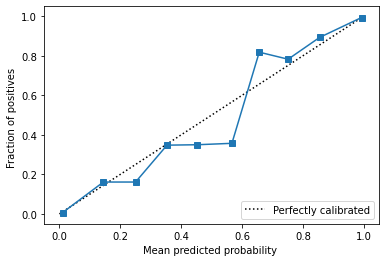

In [10]:
# Diagrama de confiabilidade
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plot_calib = CalibrationDisplay(prob_true, prob_pred, y_pred_proba)
plot_calib.plot();

In [11]:
# Definir objeto CalibratedClassifierCV usando o método isotonic regression
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=cv)

# Avaliar modelo calibrado
scores = cross_validate(calibrated, X_train, y_train, scoring=['f1', 'roc_auc'], cv=cv, n_jobs=-1)

print('F1-Score (média): %.3f' % scores['test_f1'].mean())
print('ROC/AUC (média):  %.3f' % scores['test_roc_auc'].mean())

F1-Score (média): 0.910
ROC/AUC (média):  0.986


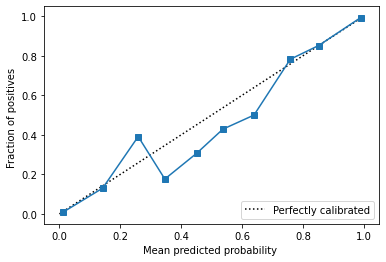

In [12]:
# Diagrama de confiabilidade
calibrated.fit(X_train, y_train)
y_pred_proba = calibrated.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plot_calib = CalibrationDisplay(prob_true, prob_pred, y_pred_proba)
plot_calib.plot();

Note que o modelo resultante do `CalibratedClassifierCV()` não parece mais bem calibrado, apesar da pequena melhora na métrica F1-score. 

O uso do `CalibratedClassifierCV()` pode piorar as métricas e até mesmo a calibração do modelo, principalmente se o número de amostras for pequeno. [Veja](https://stackoverflow.com/questions/30285551/why-does-calibratedclassifiercv-underperform-a-direct-classifer)

Vamos comparar o modelo resultante com um modelo naturalmente calibrado: regressão logística.

In [13]:
# Modelo
model = LogisticRegression(random_state=0)

# Avaliar modelo com a métrica F1-score
scores = cross_validate(model, X_train, y_train, scoring=['f1', 'roc_auc'], cv=cv, n_jobs=-1)

print('F1-Score (média): %.3f' % scores['test_f1'].mean())
print('ROC/AUC (média):  %.3f' % scores['test_roc_auc'].mean())

F1-Score (média): 0.576
ROC/AUC (média):  0.814


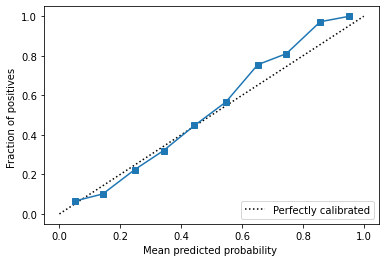

In [14]:
# Diagrama de confiabilidade
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plot_calib = CalibrationDisplay(prob_true, prob_pred, y_pred_proba)
plot_calib.plot();

Note que, enquanto a calibração é quase perfeita, as métricas do modelo são piores.

### Calibração como hiperparâmetro

Também é possível usar o método de calibração como um hiperparâmetro dentro do seu *pipeline* de seleção [[MLM1](https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/)]:

In [16]:
from sklearn.model_selection import GridSearchCV

# Modelo
model = SVC(probability=True)

# Definir objeto CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model)

# Definir grid
param_grid = dict(cv=[2,3,4], method=['sigmoid','isotonic'])

# Definir método de validação cruzada para avaliar o modelo
cv = StratifiedKFold()

# # Todos os resultados
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [17]:
# grid search
grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
grid_result = grid.fit(X_train, y_train)

In [18]:
# Melhor resultado
print("Melhor resultado: F1-score = %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

Melhor resultado: F1-score = 0.908871 usando {'cv': 4, 'method': 'sigmoid'}


In [21]:
# Avaliar modelo calibrado
calibrated = CalibratedClassifierCV(model, **grid_result.best_params_)

scores = cross_validate(calibrated, X_train, y_train, scoring=['f1', 'roc_auc'], cv=cv, n_jobs=-1)

print('F1-Score (média): %.3f' % scores['test_f1'].mean())
print('ROC/AUC (média):  %.3f' % scores['test_roc_auc'].mean())

F1-Score (média): 0.909
ROC/AUC (média):  0.985


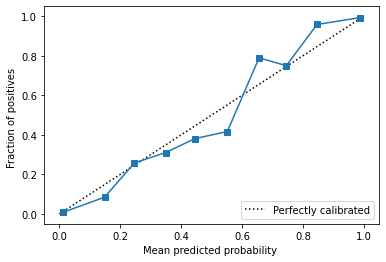

In [20]:
# Diagrama de confiabilidade
calibrated.fit(X_train, y_train)
y_pred_proba = calibrated.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plot_calib = CalibrationDisplay(prob_true, prob_pred, y_pred_proba)
plot_calib.plot();

As métricas do modelo se mantiveram altas e a calibração parece melhor.

## Conclusão

Como vimos, a calibração de modelos é um tópico extenso, e não há resposta definitiva sobre como calibrar modelos. Neste *Notebook* apresentamos diversos conceitos e métodos disponíveis para avaliar a calibração de modelos de classificação binária, e um método para calibrar modelos. 

Note que a calibração também está disponível para modelos de classificação multiclasse e de regressão, mas como este *Notebook* já está longo demais, decidi dividir o conteúdo em uma série: "Calibração de modelos".